In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier


In [ ]:
DATASET_PATH = "/content/drive/MyDrive/faysond/genres_original"
genres = os.listdir(DATASET_PATH)

def extract_features(file_path, segment_duration=3):
    y, sr = librosa.load(file_path, duration=30)
    hop_length = sr * segment_duration
    num_segments = len(y) // hop_length

    features = []
    for i in range(num_segments):
        start = i * hop_length
        end = start + hop_length
        segment = y[start:end]

        if len(segment) < hop_length:
            continue

        mfccs = np.mean(librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=20).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=segment, sr=sr).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=segment, sr=sr).T, axis=0)
        contrast = np.mean(librosa.feature.spectral_contrast(y=segment, sr=sr).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(segment), sr=sr).T, axis=0)

        features.append(np.hstack([mfccs, chroma, mel, contrast, tonnetz]))

    return features


In [ ]:
# **Loading the data**
data = []
labels = []

for genre in genres:
    genre_path = os.path.join(DATASET_PATH, genre)
    for file in os.listdir(genre_path):
        file_path = os.path.join(genre_path, file)
        try:
            feature_segments = extract_features(file_path)
            for segment in feature_segments:
                data.append(segment)
                labels.append(genre)
        except Exception as e:
            print(f"Skipping {file}: {e}")

    print(f"Loaded samples from genre: {genre}")

✅ Loaded samples from genre: blues
✅ Loaded samples from genre: classical
✅ Loaded samples from genre: country
✅ Loaded samples from genre: disco
✅ Loaded samples from genre: hiphop
✅ Loaded samples from genre: jazz
✅ Loaded samples from genre: pop
✅ Loaded samples from genre: metal
✅ Loaded samples from genre: reggae
✅ Loaded samples from genre: rock


In [ ]:
df = pd.DataFrame(data)
df["genre"] = labels

label_encoder = LabelEncoder()
df["genre"] = label_encoder.fit_transform(df["genre"])

X = df.drop(columns=["genre"])
y = df["genre"]

X_train, X_test_final, y_train, y_test_final = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test_final = scaler.transform(X_test_final)


In [ ]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

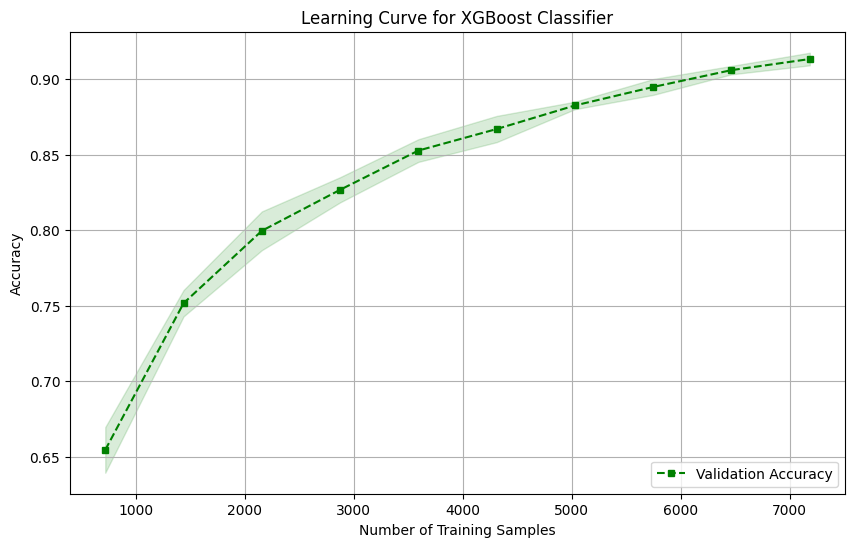

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid()
plt.title('Learning Curve for XGBoost Classifier')
plt.show()


In [ ]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    learning_rate=0.05,
    max_depth=8,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.2
)

print("Starting Training...")
xgb_model.fit(X_train, y_train)
print("Training Completed!")

Starting Training...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:34:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Completed!


In [ ]:
y_pred_final = xgb_model.predict(X_test_final)
accuracy = accuracy_score(y_test_final, y_pred_final)
print(f"\nFinal Model Accuracy on Test Set: {accuracy * 100:.2f}%")


Final Model Accuracy on Test Set: 93.19%


In [ ]:
print("\nClassification Report:")
print(classification_report(y_test_final, y_pred_final, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

       blues       0.95      0.96      0.96       100
   classical       0.96      1.00      0.98       100
     country       0.88      0.94      0.91       100
       disco       0.95      0.92      0.93       100
      hiphop       0.95      0.90      0.92       100
        jazz       0.93      0.94      0.93        99
       metal       0.92      0.97      0.95       100
         pop       0.98      0.92      0.95       100
      reggae       0.92      0.92      0.92       100
        rock       0.89      0.85      0.87       100

    accuracy                           0.93       999
   macro avg       0.93      0.93      0.93       999
weighted avg       0.93      0.93      0.93       999



In [ ]:
xgb_model.save_model("music_genre_model3.json")
np.save("label_encoder3.npy", label_encoder.classes_)
np.save("scaler3.npy", scaler)